In [54]:
import pandas as pd
import yfinance as yf
from datetime import date
from yfetch import get_stock_history, get_option_chains


In [55]:
symbol = 'NVDA'
expiry = '2026-09-18' 


In [56]:
ticker = yf.Ticker(symbol)
if expiry not in ticker.options:
  print(f'{symbol} expirations:')
  for x in ticker.options:
      print(x)
  print('Pick one and set in expiry variable')

In [57]:
assert expiry in ticker.options, f'Invalid expiry {expiry} for {symbol}'
calendar_days = (date.fromisoformat(expiry) - date.today()).days
trading_days = round(calendar_days * 252 / 365)
sma_days = trading_days
 
history = get_stock_history(symbol, interval='1d')
history['SMA'] = history['Close'].rolling(window=sma_days).mean()
history['SMA_dist'] = history.Close / history.SMA - 1
history['Change'] = history.Close.pct_change(periods=trading_days)

last_close = history.Close.iloc[-1]
last_sma = history.SMA.iloc[-1]
median_dist = history.SMA_dist.median()
norm_price = last_sma * (1 + median_dist)
median_change = history.Change.median()
future_price = norm_price * (1 + median_change)

print(symbol)
print(f'Last close: ${last_close:.2f}')
# print(f'SMA {sma_days}d: ${last_sma:.2f}')
print(f'Median SMA dist: {median_dist:+.2%}')
# print(f'Norm price: ${norm_price:.2f}')
print(f'Median change over {trading_days}d: {median_change:.2%}')
print(f'Expected price on {expiry}: ${future_price:.2f}')

NVDA
Last close: $178.19
Median SMA dist: +33.37%
Median change over 242d: 79.04%
Expected price on 2026-09-18: $338.11


In [58]:
chains = get_option_chains(symbol, expiry=expiry)
print(f'{symbol} price on {chains.market_date}: ${chains.stock_price:.2f}')

chain = chains.chains[expiry]
calls = chain.get_otm_calls()
print(f'OTM calls expiring on {expiry}:')
for strike, call_price in calls:
  print(f'${strike:.2f} - ${call_price:.2f}')

NVDA price on 2025-10-02: $188.94
OTM calls expiring on 2026-09-18:
$190.00 - $33.83
$195.00 - $31.57
$200.00 - $29.40
$210.00 - $25.45
$220.00 - $21.90
$230.00 - $18.85
$240.00 - $16.18
$250.00 - $13.88
$260.00 - $11.88
$270.00 - $10.12
$280.00 - $8.68
$290.00 - $7.45
$300.00 - $6.40
$310.00 - $5.53
$320.00 - $4.75
$330.00 - $4.10
$340.00 - $3.55
$350.00 - $3.08
$360.00 - $2.68


,Strike,Call Price,ITM,Profit
0,190.0,33.825,148.113389,337.881417
1,195.0,31.575,143.113389,353.249056
2,200.0,29.400,138.113389,369.773433
3,210.0,25.450,128.113389,403.392493
4,220.0,21.900,118.113389,439.330545
5,230.0,18.850,108.113389,473.545832
6,240.0,16.175,98.113389,506.574278
7,250.0,13.875,88.113389,535.051455
8,260.0,11.875,78.113389,557.796964
9,270.0,10.125,68.113389,572.724834


<Axes: title={'center': 'Projected NVDA Call Profit on 2026-09-18 at $338.11'}, xlabel='Strike Price', ylabel='Profit %'>

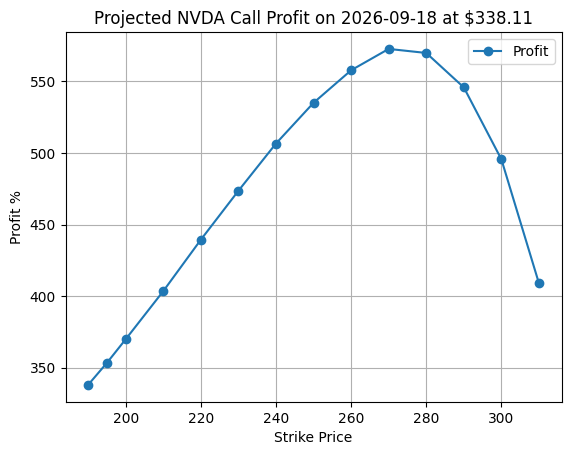

In [66]:
rows = []
for strike, call_price in calls:
  itm = max(0, future_price - strike)
  profit = max(-1, itm / call_price - 1)
  rows.append({
    'Strike': strike,
    'Call Price': call_price,
    'ITM': itm,
    'Profit': profit * 100,
  })

df = pd.DataFrame(rows)
display(df)
df[:-5].plot(
  x='Strike', 
  y='Profit', 
  kind='line', 
  marker='o', 
  title=f'Projected {symbol} Call Profit on {expiry} at ${future_price:.2f}', 
  xlabel='Strike Price', 
  ylabel='Profit %', 
  grid=True)